In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [2]:
def importData(location):
    data = pd.read_csv(location, sep=';')
    data.columns = data.columns.str.replace(' ', '_')
    listCommatoDot = ["add_to_cart_per_session", "avg_order_value","discount_rate_per_visited_products","product_detail_view_per_app_session","add_to_cart_per_session"]
    # comma to dot converter
    for i in listCommatoDot:
        data[i] = data[i].str.replace(',','.')
    columnList = ["add_to_cart_per_session","avg_order_value","discount_rate_per_visited_products","product_detail_view_per_app_session","add_to_cart_per_session"]
    # changing of type from object to float  
    for j in columnList:
        data[j] = pd.to_numeric(data[i], errors = 'coerce')  
    is_null_any = data.isna().sum().sum()
    print(f'Data include {is_null_any} missing value.')
    return data

In [3]:
data = importData('data.csv')

Data include 0 missing value.


In [4]:
data.describe().T
# app_transaction right skewed
# customer_service_calls right skewed
# add_to_wishlist right skewed

,count,mean,std,min,25%,50%,75%,max
account_length,3333.0,1.010648e+02,39.822106,1.0,74.0,101.00,127.00,243.0
location_code,3333.0,4.371824e+02,42.371290,408.0,408.0,415.00,510.00,510.0
user_id,3333.0,3.746291e+06,274662.573752,3271058.0,3508680.0,3748187.00,3985970.00,4229964.0
add_to_wishlist,3333.0,8.099010e+00,13.688365,0.0,0.0,0.00,20.00,51.0
desktop_sessions,3333.0,1.798119e+02,54.457135,0.0,144.0,179.00,216.00,351.0
app_sessions,3333.0,3.056796e+01,9.269376,0.0,24.0,31.00,37.00,60.0
desktop_transactions,3333.0,1.708761e+01,4.323795,0.0,14.0,17.00,20.00,31.0
total_product_detail_views,3333.0,1.004356e+02,20.069084,0.0,87.0,101.00,114.00,165.0
session_duration,3333.0,2.010396e+02,50.714359,0.0,167.0,201.00,235.00,364.0
promotion_clicks,3333.0,1.001107e+02,19.923911,0.0,87.0,100.00,114.00,170.0


In [5]:
data.dtypes
# I do not use type of object values so, I convert them except credit_card_info_save_column and push_status.
# You can see at the beginning of the oop structure.
# They are not integer/float, their rows include yes no and I will change with dummy/labelencoder

account_length                           int64
location_code                            int64
user_id                                  int64
credit_card_info_save                   object
push_status                             object
add_to_wishlist                          int64
desktop_sessions                         int64
app_sessions                             int64
desktop_transactions                     int64
total_product_detail_views               int64
session_duration                         int64
promotion_clicks                         int64
avg_order_value                        float64
sale_product_views                       int64
discount_rate_per_visited_products     float64
product_detail_view_per_app_session    float64
app_transactions                         int64
add_to_cart_per_session                float64
customer_service_calls                   int64
churn                                    int64
dtype: object

In [6]:
# There are only 3 types of value, so I have to standardize it.
locations = [415,510,408]

for i in locations:
    if i == 415:
        data["location_code"] = data["location_code"].replace(i,1)
    elif i == 510:
        data["location_code"] = data["location_code"].replace(i,2)
    elif i == 408:
        data["location_code"] = data["location_code"].replace(i,3)
    else:
        print("error")

In [7]:
data["customer_service_calls"].value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: customer_service_calls, dtype: int64

In [8]:
def getDummies(data):
    data['credit_card_info_save'] = pd.get_dummies(data["credit_card_info_save"])
    data['push_status'] = pd.get_dummies(data["push_status"])
    
getDummies(data)

In [9]:
group = data.groupby(["customer_service_calls","churn"])
group.first()

# Generally I can say, when number of customer calls increase, churn increases.

account_length  location_code  user_id  \
customer_service_calls churn                                           
0                      0                 137              1  3581921   
                       1                 135              3  3836029   
1                      0                 128              1  3824657   
                       1                  12              3  3601596   
2                      0                  84              3  3759999   
                       1                 106              2  3953026   
3                      0                  75              1  3306626   
                       1                 121              3  3707574   
4                      0                  62              1  3669238   
                       1                  65              1  3296603   
5                      0                  75              1  3748525   
                       1                  77              3  3937984   
6                      0                 165              2  4027746   
                       1                 103              2  3273587   
7                      0                 122              3  3921616   
                       1                  86              1  3803437   
8                      0                  64              2  3338822   
                       1                 103              3  3711727   
9                      1                 152              1  4162778   

                              credit_card_info_save  push_status  \
customer_service_calls churn                                       
0                      0                          1            1   
                       1                          0            0   
1                      0                          1            0   
                       1                          1            1   
2                      0                          0            1   
                       1                          1            1   
3                      0                          0            1   
                       1                          1            0   
4                      0                          1            1   
                       1                          1            1   
5                      0                          1            0   
                       1                          1            1   
6                      0                          1            1   
                       1                          1            0   
7                      0                          1            0   
                       1                          1            1   
8                      0                          1            0   
                       1                          1            1   
9                      1                          0            0   

                              add_to_wishlist  desktop_sessions  app_sessions  \
customer_service_calls churn                                                    
0                      0                    0               243            41   
                       1                   41               173            29   
1                      0                   25               265            45   
                       1                    0               250            42   
2                      0                    0               299            51   
                       1                    0               211            36   
3                      0                    0               167            28   
                       1                   30               198            34   
4                      0                    0               121            21   
                       1                    0               129            22   
5                      0                   21               176            30   
                       1           

In [10]:
data.groupby(['location_code','churn','customer_service_calls']).agg({'churn':'count'})

# In the first location, when churn value equal to 1, there was a problem about communication 
# First of all, 34 people talked more than 5 times so if the customer services can not solve a problem customers will be gone already.
# Same situation is exactly true for other two location

churn
location_code churn customer_service_calls       
1             0     0                         316
                    1                         510
                    2                         336
                    3                         196
                    4                          43
                    5                          13
                    6                           3
                    7                           2
              1     0                          42
                    1                          67
                    2                          37
                    3                          19
                    4                          37
                    5                          23
                    6                           7
                    7                           3
                    9                           1
2             0     0                         148
                    1                         250
                    2                         167
                    3                         117
                    4                          20
                    5                           8
                    6                           3
                    7                           1
                    8                           1
              1     0                          25
                    1                          26
                    2                          24
                    3                          13
                    4                          25
                    5                           9
                    6                           3
3             0     0                         141
                    1                         299
                    2                         169
                    3                          72
                    4                          27
                    5                           5
                    6                           2
                    7                           1
              1     0                          25
                    1                          29
                    2                          26
                    3                          12
                    4                          14
                    5                           8
                    6                           4
                    7                           2
                    8                           1
                    9                           1

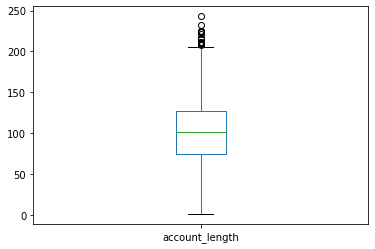

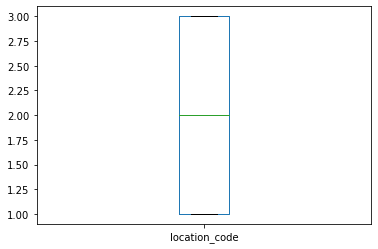

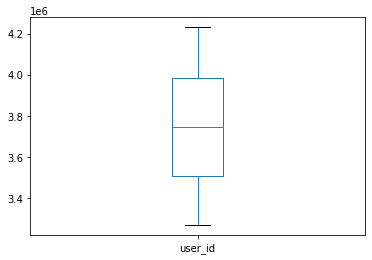

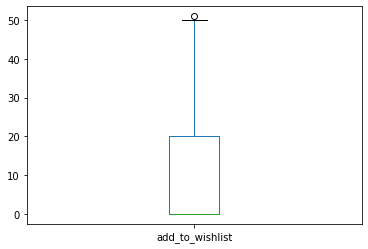

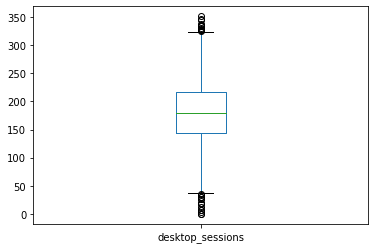

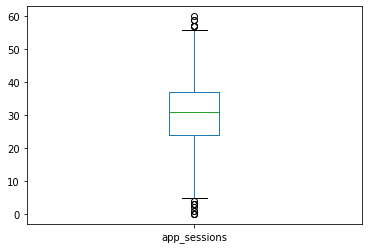

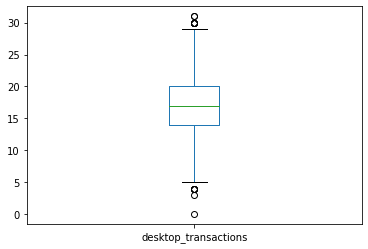

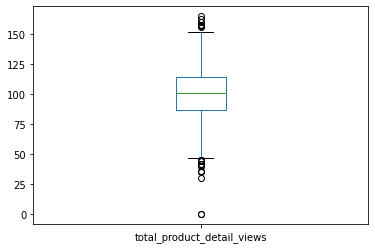

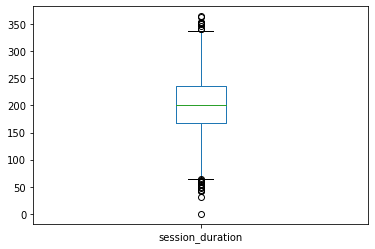

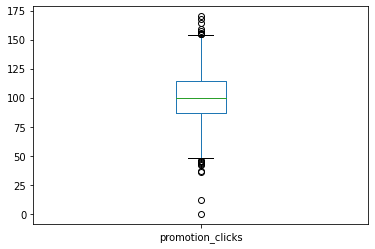

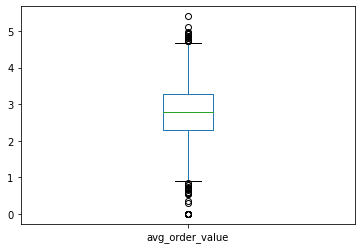

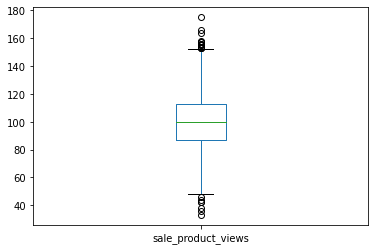

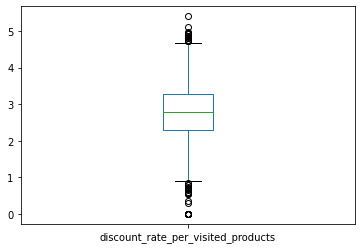

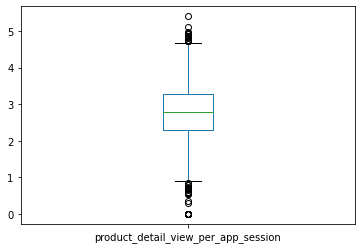

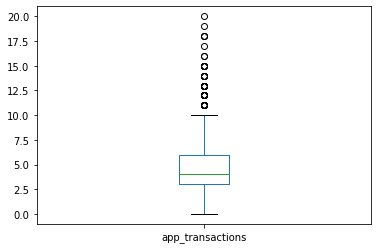

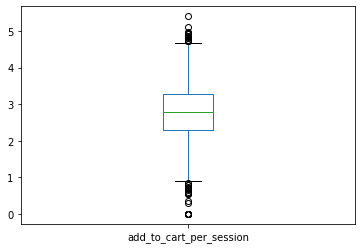

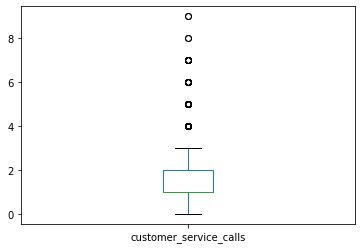

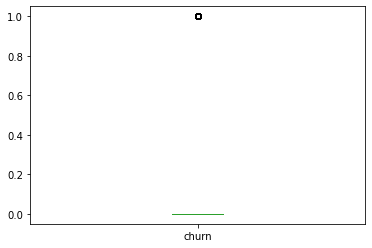

In [11]:
def visualizeBoxplot(data):
    visualize = data.drop(["credit_card_info_save","push_status"],axis=1)   
    # Columns that I dropped are categorical variables and it would not be appropriate
    for i in visualize.columns:
        visualize[i].plot(kind='box')
        plt.show()

# It could be seen exactly right skewed variables and this is how you can see how the distributions look like
visualizeBoxplot(data)

In [12]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')
# There are negative affect between churn and [credit_card_info_save, add_to_wishlist, app_transactions] so it can be overfitting because it affects target variable.
# There are positive relationship between churn and [push_status, desktop_sessions, app_sessions, desktop_transactions, session_duration, customer_service_calls]
# If seller provides to stay more time in the page, consumer tends to remain as a customer.
# When customer service calls increase, churn affects positive but  I think it contains only good calls. Because when I looked data
# I saw when people calls customer service more than 5 times, most of people exit(quit) from customers.

,account_length,location_code,user_id,credit_card_info_save,push_status,add_to_wishlist,desktop_sessions,app_sessions,desktop_transactions,total_product_detail_views,session_duration,promotion_clicks,avg_order_value,sale_product_views,discount_rate_per_visited_products,product_detail_view_per_app_session,app_transactions,add_to_cart_per_session,customer_service_calls,churn
account_length,1.000000,0.006123,0.004808,-0.024735,-0.002918,-0.004628,0.006191,0.007158,-0.007882,0.038470,-0.006790,0.019136,0.009546,-0.013176,0.009546,0.009546,0.020661,0.009546,-0.003796,0.016541
location_code,0.006123,1.000000,-0.020591,-0.000214,0.020213,-0.020857,-0.034426,-0.034699,0.003312,-0.003282,0.005760,-0.016499,-0.034783,-0.025441,-0.034783,-0.034783,-0.026650,-0.034783,-0.006091,0.004517
user_id,0.004808,-0.020591,1.000000,-0.019941,-0.030755,0.022569,0.012035,0.011246,-0.017838,-0.005812,-0.017708,0.003468,-0.010245,0.014034,-0.010245,-0.010245,-0.017676,-0.010245,0.033847,0.005730
credit_card_info_save,-0.024735,-0.000214,-0.019941,1.000000,0.006006,-0.008745,-0.049411,-0.050507,-0.022451,-0.003755,-0.019305,-0.006172,-0.045780,-0.012451,-0.045780,-0.045780,-0.017366,-0.045780,0.024522,-0.259852
push_status,-0.002918,0.020213,-0.030755,0.006006,1.000000,-0.956927,0.001423,0.002508,-0.023307,0.011086,-0.021501,0.006736,0.001276,-0.015553,0.001276,0.001276,-0.007618,0.001276,0.017824,0.102148
add_to_wishlist,-0.004628,-0.020857,0.022569,-0.008745,-0.956927,1.000000,0.001005,0.000030,0.019325,-0.009548,0.017443,-0.006087,0.002884,0.007123,0.002884,0.002884,0.013957,0.002884,-0.013263,-0.089728
desktop_sessions,0.006191,-0.034426,0.012035,-0.049411,0.001423,0.001005,1.000000,0.999498,0.006033,0.006561,0.007216,0.015495,-0.010079,0.023060,-0.010079,-0.010079,0.008148,-0.010079,-0.013432,0.205138
app_sessions,0.007158,-0.034699,0.011246,-0.050507,0.002508,0.000030,0.999498,1.000000,0.005752,0.006363,0.006943,0.015923,-0.010157,0.022918,-0.010157,-0.010157,0.008017,-0.010157,-0.012835,0.204683
desktop_transactions,-0.007882,0.003312,-0.017838,-0.022451,-0.023307,0.019325,0.006033,0.005752,1.000000,-0.019646,0.997815,-0.009742,-0.013226,0.007323,-0.013226,-0.013226,0.000874,-0.013226,-0.014265,0.091811
total_product_detail_views,0.038470,-0.003282,-0.005812,-0.003755,0.011086,-0.009548,0.006561,0.006363,-0.019646,1.000000,-0.021409,0.006376,0.021666,-0.019557,0.021666,0.021666,0.004574,0.021666,-0.018942,0.018459


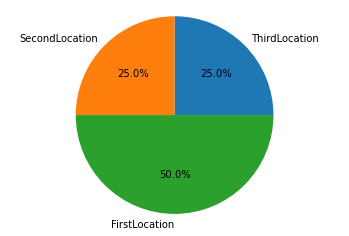

In [13]:
def pieChart():
    labels = 'ThirdLocation', 'SecondLocation', 'FirstLocation'
    sizes = [90, 90, 180]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')
    plt.show()
    
# Most of customers comes from 1st location --> 415
# It does not include the variables that in dataframes but I had to show like that.
pieChart()

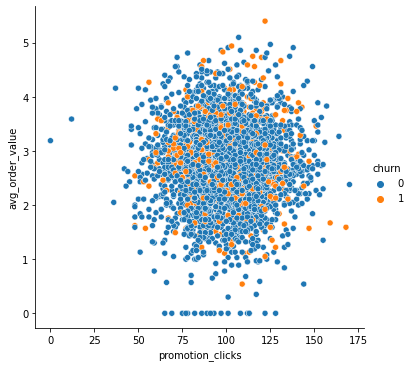

In [14]:
def scatterPlot(data):
    sns.relplot(x='promotion_clicks', y='avg_order_value',hue='churn', data=data);

    
scatterPlot(data)
# when number of promotion increases, value of order will increase most of time. It gives an opportunity to reach new people that does not be consumer

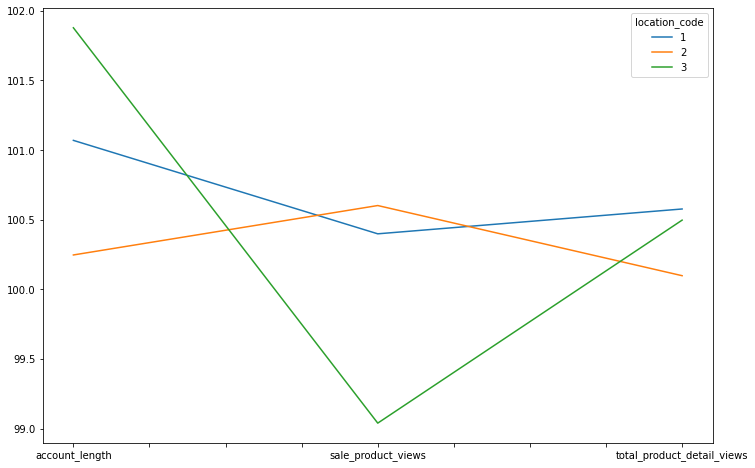

In [15]:
def groupFunction(data):
    data.groupby('location_code')[["account_length","sale_product_views","total_product_detail_views"]].mean().T.plot(figsize=(12,8));
    # Results;
    # On average, people living in the 3rd location do not show interest in addition to discounted products.
    # People living in 2nd location also follow discounted products.
groupFunction(data)

In [16]:
def normalizeData(data):
    # I have to do normalization to the all non-target variables.
    # In addition I dropped credit card info column due to overfitting. That variable causes it.
    variables = data.drop(['churn','credit_card_info_save','user_id'],axis =1)
    x = variables.values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns = variables.columns)
    return df
df = normalizeData(data)

In [17]:
df

,account_length,location_code,push_status,add_to_wishlist,desktop_sessions,app_sessions,desktop_transactions,total_product_detail_views,session_duration,promotion_clicks,avg_order_value,sale_product_views,discount_rate_per_visited_products,product_detail_view_per_app_session,app_transactions,add_to_cart_per_session,customer_service_calls
0,0.524793,0.0,0.0,0.490196,0.754986,0.750000,0.548387,0.666667,0.541209,0.511765,0.500000,0.408451,0.500000,0.500000,0.15,0.500000,0.111111
1,0.438017,0.0,0.0,0.509804,0.461538,0.450000,0.548387,0.745455,0.538462,0.605882,0.685185,0.492958,0.685185,0.685185,0.15,0.685185,0.111111
2,0.561983,0.0,1.0,0.000000,0.692308,0.683333,0.322581,0.690909,0.332418,0.647059,0.609259,0.500000,0.609259,0.609259,0.25,0.609259,0.000000
3,0.342975,1.0,1.0,0.000000,0.851852,0.850000,0.161290,0.430303,0.170330,0.517647,0.329630,0.394366,0.329630,0.329630,0.35,0.329630,0.222222
4,0.305785,0.0,1.0,0.000000,0.475783,0.466667,0.419355,0.684848,0.406593,0.717647,0.505556,0.619718,0.505556,0.505556,0.15,0.505556,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.789256,0.0,0.0,0.705882,0.444444,0.450000,0.580645,0.466667,0.593407,0.741176,0.494444,0.352113,0.494444,0.494444,0.30,0.494444,0.222222
3329,0.276860,0.0,1.0,0.000000,0.658120,0.650000,0.419355,0.345455,0.420330,0.323529,0.479630,0.633803,0.479630,0.479630,0.20,0.479630,0.333333
3330,0.111570,0.5,1.0,0.000000,0.515670,0.516667,0.806452,0.660606,0.793956,0.341176,0.705556,0.408451,0.705556,0.705556,0.30,0.705556,0.222222
3331,0.756198,0.5,1.0,0.000000,0.609687,0.600000,0.451613,0.636364,0.439560,0.494118,0.250000,0.732394,0.250000,0.250000,0.50,0.250000,0.222222


In [18]:
def xAndY(data, df):
    df_x = df.values
    X = df_x
    Y = data["churn"]
    return X, Y
X, Y = xAndY(data, df)

In [19]:
def trainTest(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 12)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = trainTest(X, Y)

In [20]:
# Feature Selection

In [21]:
def featureSelection(df, X, Y):
    #apply SelectKBest class to extract top 10 best features
    bestfeatures = SelectKBest(score_func=f_classif, k=10)
    fit = bestfeatures.fit(X, Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Score']  #naming the dataframe columns
    print(featureScores.nlargest(10, 'Score'))  #print 10 best features
featureSelection(df, X, Y)

                               Features       Score
16               customer_service_calls  151.767013
4                      desktop_sessions  146.332163
5                          app_sessions  145.654224
2                           push_status   35.122944
8                      session_duration   28.924366
6                  desktop_transactions   28.316758
3                       add_to_wishlist   27.035912
10                      avg_order_value   15.592581
12   discount_rate_per_visited_products   15.592581
13  product_detail_view_per_app_session   15.592581


[22:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


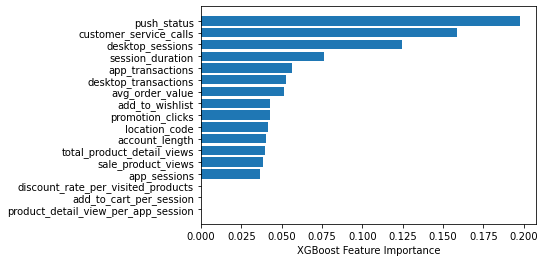

In [22]:
def featureImportanceXgb(X_train, y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=12)
    xgbc = XGBClassifier(n_estimators=100).fit(X_train, y_train)
    sorted_idx = xgbc.feature_importances_.argsort()
    plt.barh(df.columns[sorted_idx], xgbc.feature_importances_[sorted_idx])
    plt.xlabel("XGBoost Feature Importance")
featureImportanceXgb(X_train, y_train)

In [23]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:hinge']
    }

    xgb_model = XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [24]:
##Best Params
"""
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 150,
 'objective': 'binary:hinge',
 'subsample': 0.7}"""

"\n{'colsample_bytree': 0.7,\n 'learning_rate': 0.01,\n 'max_depth': 7,\n 'min_child_weight': 1,\n 'n_estimators': 150,\n 'objective': 'binary:hinge',\n 'subsample': 0.7}"

In [25]:
def modelVisualization(X_train, y_train):
    xgbc = XGBClassifier(colsample_bytree = 0.7,
                         learning_rate = 0.01,
                         max_depth = 7,
                         min_child_weight = 1,
                         n_estimators = 150,
                         objective = 'binary:hinge',
                         subsample = .7).fit(X_train, y_train)
    return xgbc

In [26]:
xgbc = modelVisualization(X_train, y_train)

In [27]:
y_pred = xgbc.predict(X_test)

cm = confusion_matrix(y_pred, y_test)
print(cm)

[[1110   87]
 [  32  105]]


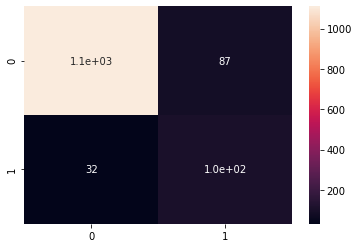

In [28]:
import seaborn as sns
sns.heatmap(cm, annot=True);

<AxesSubplot:>

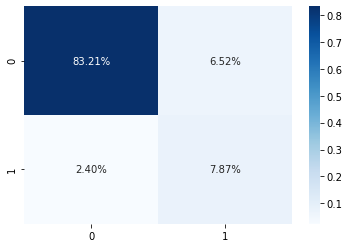

In [29]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [30]:
## version of libraries that I used

In [31]:
from importlib.metadata import version
libraries = ["xgboost", "scikit-learn","xgboost","numpy","matplotlib","seaborn"]
for i in libraries:
    a  = (f'{i}==' + version(i))
    with open("requirements.txt", 'a', encoding = 'UTF-8') as f:
        f.write(a +'\n')